In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
# !git clone --recursive https://github.com/Microsoft/LightGBM
  
# !apt-get install -y -qq libboost-all-dev

# %%bash
# cd LightGBM
# rm -r build
# mkdir build
# cd build
# cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# make -j$(nproc)

# !cd LightGBM/python-package/;python3 setup.py install --precompile

# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !rm -r LightGBM

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Here, I work on the smaller subset.

In [0]:
labels_df = pd.read_csv(f'{PATH_LABELS}/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [36]:
train_df = pd.read_pickle(f'{PATH_FEATURES}/train_df.pkl')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,0
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,0
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,0
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397,0
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941,0


In [37]:
len(sub_df)

1998200

## EDA

In [38]:
sub_df.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06
mean,8.161654e+11,1.061140e+01,1.684718e+02,7.244688e-02,4.579389e+00,9.075932e-01,-2.046001e-03,2.152561e-05,-2.651337e-04,4.199983e+03,8.423657e+00,2.493744e-01
std,4.944606e+11,7.623948e+01,1.078981e+02,1.407409e+00,8.070876e+00,3.221037e+00,1.423460e-01,3.193392e-01,1.516832e-01,1.517685e+06,7.825821e+00,4.326510e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-2.687987e+01,-5.203878e+01,-5.711064e+01,-2.927131e+01,-5.887993e+01,-2.818092e+01,0.000000e+00,-1.000000e+00,0.000000e+00
25%,3.865471e+11,3.900000e+00,7.655327e+01,-5.049608e-01,-6.440599e-01,-9.171051e-01,-2.670214e-02,-3.027998e-02,-1.878666e-02,1.660000e+02,8.132748e-01,0.000000e+00
50%,7.988639e+11,4.288000e+00,1.690000e+02,6.026306e-02,9.107821e+00,7.709565e-01,-6.933320e-04,2.288818e-04,-7.629395e-05,3.940000e+02,6.730000e+00,0.000000e+00
75%,1.245541e+12,8.000000e+00,2.630000e+02,6.343323e-01,9.713572e+00,2.743839e+00,2.282715e-02,3.158569e-02,1.810950e-02,6.940000e+02,1.435960e+01,0.000000e+00
max,1.709397e+12,6.063000e+03,3.599967e+02,5.134041e+01,5.838979e+01,7.288908e+01,1.830983e+01,5.550382e+01,4.505986e+01,6.193158e+08,8.803725e+01,1.000000e+00


In [0]:
# get highest accuracy


## Feature engineering
Some ideas are taken from this [discussion](https://www.kaggle.com/c/axa-driver-telematics-analysis/discussion/12848#latest-66913).

In [39]:
sub_df.columns.tolist()

['bookingID',
 'Accuracy',
 'Bearing',
 'acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'gyro_x',
 'gyro_y',
 'gyro_z',
 'second',
 'Speed',
 'label']

In [0]:
def total_acc(df):
    # acceleration combining all directions
    total_acc = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_acc'] = np.sqrt(total_acc)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
def roll(df):
    # roll  
    yz = df[['acceleration_y', 'acceleration_z']].values
    
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll'] = np.arctan2(y, z)
    
  
def pitch(df):
    # pitch
    xyz = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].values
    
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))
    
def horsepower(df):
    df['horsepower'] = df['total_acc'] * df['Speed']
    
def aggressive_turn(df):
    pass
  
def jerk(df):
    pass
  
def distance(df):
    pass
  
def fe(df):
    total_acc(df)
    total_gyro(df)
    roll(df)
    pitch(df)
    horsepower(df)

In [0]:
fe(sub_df)

In [0]:
accs = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'total_acc']
gyros = ['gyro_x', 'gyro_y', 'gyro_z', 'total_gyro']
speed = ['Speed']

features = accs + gyros + speed

def group_features(in_, features):
    # features grouped by bookingID
    out_ = pd.DataFrame()
    
    out_['bookingID'] = in_['bookingID'].unique()
    
    def first_order(x):
        # first order diff
        return np.mean(np.diff(x))

    def second_order(x):
        # second order diff
        return np.mean(np.diff(np.diff(x)))   
    
    # statistical features
    for feature in features:
            
        out_[feature + '_mean'] = in_.groupby('bookingID')[feature].mean().values        
        out_[feature + '_min'] = in_.groupby('bookingID')[feature].min().values
        out_[feature + '_max'] = in_.groupby('bookingID')[feature].max().values
        out_[feature + '_std'] = in_.groupby('bookingID')[feature].std().values
        
        out_[feature + '_fo_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(first_order).values  
        out_[feature + '_so_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(second_order).values                
    return out_

In [0]:
new = group_features(sub_df, features)

In [84]:
new.head()

,bookingID,Accuracy_mean,Accuracy_min,Accuracy_max,Accuracy_std,Accuracy_fo_mean,Accuracy_so_mean,Bearing_mean,Bearing_min,Bearing_max,Bearing_std,Bearing_fo_mean,Bearing_so_mean,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,...,gyro_z_max,gyro_z_std,gyro_z_fo_mean,gyro_z_so_mean,second_mean,second_min,second_max,second_std,second_fo_mean,second_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,roll_mean,roll_min,roll_max,roll_std,roll_fo_mean,roll_so_mean,pitch_mean,pitch_min,pitch_max,pitch_std,pitch_fo_mean,pitch_so_mean
0,0,10.90000,6.0,16.000,3.796596,-8.080808e-02,8.163265e-02,200.473903,1.318084,359.306244,118.361429,-1.030917,-4.320566,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.213740,0.002936,0.006258,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,...,0.209767,0.059477,-0.000295,0.000185,787.76,3.0,1587.0,544.626294,8.202020,-9.632653,7.844813,0.064309,21.240761,6.861628,2.134613e-03,-1.985995e-01,9.901510,8.357991,12.988328,0.662304,0.001975,0.005938,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,-1.740281,-2.143551,-1.353799,0.124570,0.000332,0.000800,0.067695,-0.372754,0.330529,0.096545,0.000449,-0.000329
1,1,3.66931,3.0,5.007,0.485297,1.010101e-02,-1.020408e-02,115.710000,0.000000,307.000000,86.240127,0.717172,-2.459184,-0.515797,-2.370662,3.387767,0.675866,0.005570,0.005714,9.547557,7.771339,10.728791,0.502611,0.000484,0.011288,-2.176563,-4.806848,-0.062996,0.865198,-0.002507,0.018813,-0.001604,-0.054210,0.061959,0.021566,0.000323,0.000089,-0.019800,-0.573742,0.210347,...,0.136467,0.026840,0.000283,-0.000057,576.30,7.0,1025.0,277.445618,0.404040,1.591837,7.213234,-1.000000,21.858812,6.792266,1.036210e-01,-2.316663e-01,9.870474,8.455773,10.871560,0.422207,0.000737,0.005228,0.056473,0.003648,0.589819,0.075762,0.000401,-0.001011,1.795743,1.577182,2.100661,0.092487,0.000237,-0.002176,0.052417,-0.329707,0.244965,0.068523,-0.000570,-0.000605
2,2,3.93276,3.0,6.000,1.078110,-4.485750e-18,1.812609e-17,175.660000,1.000000,354.000000,120.155726,-1.111111,-1.704082,0.365558,-1.728666,1.834015,0.699327,-0.013205,0.004715,9.835035,8.248277,11.559559,0.440514,-0.002733,-0.000464,0.180456,-3.282551,2.312870,1.021426,-0.003845,0.013999,0.008800,-0.155218,0.241234,0.057002,0.000031,-0.000480,-0.023570,-0.462000,0.297305,...,0.255884,0.039991,-0.000315,0.000131,348.09,0.0,825.0,362.261697,-6.919192,0.051020,3.126265,0.000000,9.360483,2.848020,2.691450e-17,4.531523e-18,9.919853,8.334944,11.718406,0.449217,-0.003073,-0.000383,0.100827,0.005845,0.463685,0.094258,-0.002705,0.002360,1.551822,1.328230,1.881136,0.102706,0.000382,-0.001418,-0.037055,-0.178181,0.167035,0.070280,0.001336,-0.000460
3,4,10.00000,10.0,10.000,0.000000,0.000000e+00,0.000000e+00,157.104429,6.236270,351.087494,74.694140,0.583529,1.628288,-0.297979,-2.650528,1.785162,0.598809,-0.020397,0.018062,-9.445157,-15.253134,-8.106802,0.719555,0.003562,-0.003339,-2.579531,-5.193839,-0.906488,0.774801,-0.034721,-0.012042,-0.024235,-0.113330,0.094424,0.029816,0.000165,-0.001267,0.022005,-0.343034,0.477722,...,0.234811,0.054717,-0.000210,0.001258,576.35,21.0,1079.0,328.743933,-2.606061,-7.234694,6.079600,0.000000,18.480000,5.383002,9.696969e-03,-1.014286e-01,9.842355,8.554923,16.157423,0.7410

In [85]:
new_sub = pd.merge(new, sub_df,
                      left_on='bookingID', right_on='bookingID',
                      how='inner')

new_sub.head()

,bookingID,Accuracy_mean,Accuracy_min,Accuracy_max,Accuracy_std,Accuracy_fo_mean,Accuracy_so_mean,Bearing_mean,Bearing_min,Bearing_max,Bearing_std,Bearing_fo_mean,Bearing_so_mean,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,...,Speed_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,roll_mean,roll_min,roll_max,roll_std,roll_fo_mean,roll_so_mean,pitch_mean,pitch_min,pitch_max,pitch_std,pitch_fo_mean,pitch_so_mean,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,total_acc,total_gyro,roll,pitch
0,0,10.9,6.0,16.0,3.796596,-0.080808,0.081633,200.473903,1.318084,359.306244,118.361429,-1.030917,-4.320566,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.21374,0.002936,0.006258,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,...,-0.198599,9.90151,8.357991,12.988328,0.662304,0.001975,0.005938,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,-1.740281,-2.143551,-1.353799,0.12457,0.000332,0.0008,0.067695,-0.372754,0.330529,0.096545,0.000449,-0.000329,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,0,9.736742,0.038187,-1.758731,0.067919
1,0,10.9,6.0,16.0,3.796596,-0.080808,0.081633,200.473903,1.318084,359.306244,118.361429,-1.030917,-4.320566,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.21374,0.002936,0.006258,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,...,-0.198599,9.90151,8.357991,12.988328,0.662304,0.001975,0.005938,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,-1.740281,-2.143551,-1.353799,0.12457,0.000332,0.0008,0.067695,-0.372754,0.330529,0.096545,0.000449,-0.000329,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,0,9.617129,0.021580,-1.734776,0.070214
2,0,10.9,6.0,16.0,3.796596,-0.080808,0.081633,200.473903,1.318084,359.306244,118.361429,-1.030917,-4.320566,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.21374,0.002936,0.006258,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,...,-0.198599,9.90151,8.357991,12.988328,0.662304,0.001975,0.005938,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,-1.740281,-2.143551,-1.353799,0.12457,0.000332,0.0008,0.067695,-0.372754,0.330529,0.096545,0.000449,-0.000329,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,0,9.342461,0.057394,-1.982926,0.127013
3,0,10.9,6.0,16.0,3.796596,-0.080808,0.081633,200.473903,1.318084,359.306244,118.361429,-1.030917,-4.320566,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.21374,0.002936,0.006258,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,...,-0.198599,9.90151,8.357991,12.988328,0.662304,0.001975,0.005938,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,-1.740281,-2.143551,-1.353799,0.12457,0.000332,0.0008,0.067695,-0.372754,0.330529,0.096545,0.000449,-0.000329,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.7283

In [0]:
features = [c for c in sub_df.columns if c not in ['label', 'bookingID']]

# features

Normalize according to drivers.

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm import tqdm

def normalize_by_ids(df):
    drivers = df['bookingID'].unique()
    for driver in tqdm(drivers):
        ids = df[df['bookingID'] == driver].index
        scaler = MinMaxScaler()
        df.loc[ids, features] = scaler.fit_transform(df.loc[ids, features])
        
normalize_by_ids(sub_df)

 37%|███▋      | 7360/19982 [26:16<44:27,  4.73it/s]

In [29]:
sub_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,total_acc,total_gyro,roll,pitch
0,0,0.153199,-0.248637,-0.495209,-1.406968,-0.654444,-0.000664,-0.117204,0.123951,-0.730232,-1.019440,0,-0.135591,-0.297576,-1.358939,0.451165
1,0,-0.038934,1.361880,-0.503721,-1.398345,-0.586646,0.004666,-0.064913,0.086987,1.120184,-0.703508,0,-0.178502,-0.346534,-1.343359,0.463071
2,0,0.153199,-0.230006,-0.815109,-1.291426,-1.171360,0.162895,-0.009804,0.423839,-0.876510,0.394933,0,-0.277039,-0.240955,-1.504760,0.757672
3,0,0.153199,0.699658,-0.458231,-1.581093,-0.292191,-0.210950,-0.073882,-0.087317,-0.588830,-0.568894,0,0.373346,-0.283284,-1.265054,0.378175
4,0,-0.038934,-1.218255,-0.635251,-1.328265,-0.683209,0.286975,-0.060226,0.275605,1.351791,0.541419,0,-0.372317,-0.244235,-1.376048,0.608037


## Feature selection

In [0]:


# useless_features = []

# exclude = []

## Baseline

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

In [0]:
# X_train = sub_df[lgb_features]
# y_train = sub_df['label'].values

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = sub_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
# len(oof), len(X_train), len(y_train)

train = sub_df

# features = [c for c in train.columns if c not in ['bookingID', 'label']]

In [34]:
%%time
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
#     'device': 'gpu',
#     'gpu_platform_id': 0,
#     'gpu_device_id': 0,
    "seed": random_state
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(train, train['label'])):
    X_train, y_train = train.iloc[trn_idx][features], train.iloc[trn_idx]['label']
    X_valid, y_valid = train.iloc[val_idx][features], train.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.660913	valid_1's auc: 0.660124
[200]	training's auc: 0.672789	valid_1's auc: 0.670202
[300]	training's auc: 0.680887	valid_1's auc: 0.676806
[400]	training's auc: 0.689041	valid_1's auc: 0.683677
[500]	training's auc: 0.695363	valid_1's auc: 0.688504
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.695363	valid_1's auc: 0.688504
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.661417	valid_1's auc: 0.659926
[200]	training's auc: 0.671552	valid_1's auc: 0.668753
[300]	training's auc: 0.680722	valid_1's auc: 0.676414
[400]	training's auc: 0.689176	valid_1's auc: 0.683279
[500]	training's auc: 0.695646	valid_1's auc: 0.68842
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.695646	valid_1's auc: 0.68842
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.660974	valid_1's auc: 0.659932


KeyboardInterrupt: ignored

In [80]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.669646519, std: 0.000948972. All auc: 0.669641411.


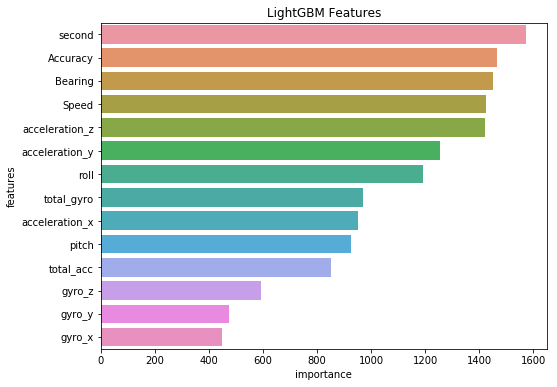

In [81]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="features", 
            data=features_df.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features')
plt.show()